<a href="https://colab.research.google.com/github/JoshStrong/MAML/blob/master/MAML_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install learn2learn

In [2]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random

import copy

import learn2learn as l2l

In [3]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(1, 40)
    self.fc2 = nn.Linear(40, 40)
    self.fc3 = nn.Linear(40, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

In [5]:
class Sine_Task_Distribution():
  def __init__(self, power_min, power_max, amplitude_min, amplitude_max, phase_min, phase_max, xmin, xmax):
    self.power_min = power_min
    self.power_max = power_max
    self.amplitude_min = amplitude_min
    self.amplitude_max = amplitude_max
    self.phase_min = phase_min
    self.phase_max = phase_max
    self.xmin = xmin
    self.xmax = xmax

  def sample_task(self):
    amplitude = np.random.uniform(self.amplitude_min, self.amplitude_max)
    power = np.random.randint(self.power_min,self.power_max+1)
    phase = np.random.uniform(self.phase_min, self.phase_max)

    return Sine_Task(power, amplitude, phase, self.xmin, self.xmax)

In [6]:
class Sine_Task():
  def __init__(self, power, amplitude, phase, xmin, xmax):
    self.power = power
    self.phase = phase
    self.amplitude = amplitude
    self.xmin = xmin
    self.xmax = xmax

  def oracle(self, x):
    """
    Oracle: returns output of sin function with given amplitude, phase and input x

    PARAMETERS:
    1. x - input
    """
    return self.amplitude * (x **self.power) * np.sin(self.phase + x)

  def sample_data(self, size=1):
    """
      sample_data: sample input/output of given instance of Sine_Task with set variables

      PARAMETERS:
      1. size - amount of sampled data
    """
    x = torch.rand(size)*(self.xmax-self.xmin) - self.xmax
    y = self.oracle(x)
    x = x.unsqueeze(1).cuda()
    y = y.unsqueeze(1).cuda()

    return x, y

In [7]:
dist = Sine_Task_Distribution(0,1,0.1,5,0,np.pi,-5,5)

The (shortened) MAML algorithm:




*   Sample task (or a batch of tasks) $\mathcal{T}_i$.
*   Sample $D_i^{tr}, D_i^{test}$ from sampled task $\mathcal{T}_i$.
*   Inner Loop: Optimise meta-parameters $\theta$ on task $\mathcal{T}_i$ to produce task-specific optimal parameters $\phi_i$: $\phi_i \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}(\theta, D_i^{tr})$
*   Outer Loop: Update $\theta$ using stochastic gradient descent:
$\theta \leftarrow \theta - \beta \nabla_\theta \mathcal{L}(\phi, D_i^{test})$

where $\mathcal{L}(\cdot, \cdot)$ is the chosen loss function of the network (MSE for regression & binary cross entropy for classification).



Let $U(\theta, D^{tr}) := \phi = \theta - \alpha \nabla_\theta \mathcal{L}(\theta, D^{tr})$ denote the update rule used for optimising $\phi$.



The meta-optimisation objective is given as 
\begin{align*}
    \underset{\theta}{\min}\,\,\mathcal{L}(\phi, D^{test}) = \underset{\theta}{\min}\,\,\mathcal{L}(U(\theta, D^{tr}), D^{test}).
\end{align*}
We require $\frac{d}{d\theta}\mathcal{L}(\phi, D^{test})$
\begin{align*}
    \frac{d}{d\theta}\mathcal{L}(\phi, D^{test}) &= \frac{d}{d\theta}\mathcal{L}(U(\theta, D^{tr}), D^{test})\\
    &= \underbrace{\nabla_{\Theta}\mathcal{L}(\Theta, D^{test})|_{\Theta=U(\theta, D^{tr})}}_{(1)} \underbrace{\dfrac{d}{d \theta} U(\theta, D^{tr})}_{(2)} && (\text{via chain rule})
\end{align*}

(1) is a row vector which can be computed through a single backwards pass of the network, when setting parameters to $\Theta$ then differentiating loss $\mathcal{L}$ with respects to $\Theta$. The hessian matrix (2) is obtained through differentiating the update rule $U(\theta, D^{tr}) = \theta - \alpha \nabla_\theta \mathcal{L}(\theta, D^{tr})$ with respects to $\theta$. Fortunately for us, autodiff libraries such as Tensorflow and PyTorch can compute vector hessian products efficiently.

In [8]:
def main():
  device = torch.device('cuda')
  fast_lr = 0.02
  meta_lr = 0.02
  num_iterations = 6000
  meta_batch_size = 1000
  K = 10
  adaptation_steps = 1

  model = Model()
  model.to(device)
  maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False)
  opt = torch.optim.Adam(maml.parameters(), meta_lr)
  loss = nn.MSELoss(reduction='mean')
  meta_valid_error_arr = []

  # 3. Meta-learning
  # Outer-loop
  for iteration in tqdm(range(num_iterations+1)):
    opt.zero_grad()
    meta_valid_error = 0.0
    for task in range(meta_batch_size):
      # Make copy of maml class
      learner = maml.clone()

      # Sample a batch of training data
      task = dist.sample_task()
      X_train, y_train = task.sample_data(K)

      # Inner-loop
      for step in range(adaptation_steps):
        train_error = loss(learner(X_train), y_train)
        learner.adapt(train_error)

      # Sample new data validation data, calculate error
      X_valid, y_valid = task.sample_data(K)
      valid_error = loss(learner(X_valid),y_valid)

      # Backpropagate loss wrt meta-parameters to get parameter gradients
      # These accumulate by function, so no need to continuously add
      # We opt.zero_grad at each iteration instead
      valid_error.backward()

      # add evaluation_error
      meta_valid_error += valid_error.item()


    if iteration % 50 == 0:
      print('\n')
      print('Iteration', iteration)
      print('Average Meta Valid Error', meta_valid_error / meta_batch_size)
      meta_valid_error_arr.append(meta_valid_error / meta_batch_size)

    # Average the accumulated gradients and optimize
    for p in maml.parameters():
      p.grad.data.mul_(1.0 / meta_batch_size)
    opt.step() # optimise meta-parameters

  return maml

In [ ]:
## WARNING: Takes a long time to train
maml_model = main()

In [ ]:
# Save the meta-parameters to a file
# Need to clip 'module.' from parameter keys in order to reload the model first
maml_dict = maml_model.state_dict()
prefix = 'module.'
n_clip = len(prefix)
adapted_dict = {k[n_clip:]: v for k, v in maml_dict.items()
                if k.startswith(prefix)}

PATH = "/content/model"
torch.save(adapted_dict, PATH)

In [10]:
# Load MAML parameters
PATH = "/content/model"
saved_model = Model()
saved_model.load_state_dict(torch.load(PATH), strict=False)
saved_model.to('cuda')

Model(
  (fc1): Linear(in_features=1, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
)

In [11]:
seed=1
np.random.seed(seed)

testing_task1=dist.sample_task()
testing_task2=dist.sample_task()
print("testing_task1 has power",testing_task1.power)
print("testing_task2 has power",testing_task2.power)

testing_task1 has power 0
testing_task2 has power 1


In [12]:
fine_tuned_model1 = copy.deepcopy(saved_model)
fine_tuned_model2 = copy.deepcopy(saved_model)

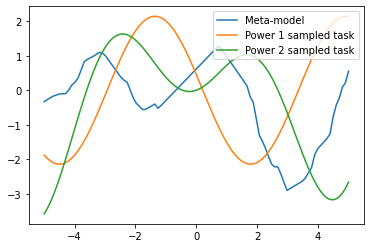

In [13]:
x = torch.linspace(-5,5).cuda()
output = [saved_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),output,label="Meta-model")
plt.plot(x.cpu(),testing_task1.oracle(x.cpu()),label="Power 1 sampled task")
plt.plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Power 2 sampled task")

plt.legend(loc="upper right")
plt.show()

In [14]:
## Fine-tuning

# Sample a task

#testing_task = dist.sample_task()
#print("Sample task has amplitude",testing_task.amplitude,"and phase",testing_task.phase)

x_train,y_train = testing_task1.sample_data(10)

fine_tuning_steps=10
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(fine_tuned_model1.parameters(),lr=0.02)

for step in range(fine_tuning_steps):
  y_pred = fine_tuned_model1(x_train)

  loss = criterion(y_pred,y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if step == 1:
    fine_tuned_once_model1 = copy.deepcopy(saved_model)
  if step == 5:
    fine_tuned_five_model1 = copy.deepcopy(saved_model)

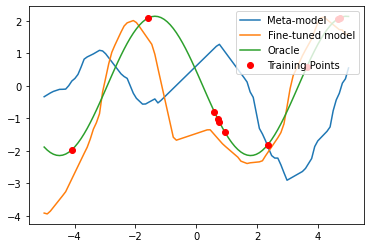

In [15]:
output = [saved_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
#output1 = [fine_tuned_once_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
#output2 = [fine_tuned_five_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
output3 = [fine_tuned_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),output,label="Meta-model")
#plt.plot(x.cpu(),output1,label="Fine-tuned once")
#plt.plot(x.cpu(),output2,label="Fine-tuned five")
plt.plot(x.cpu(),output3,label="Fine-tuned model")
plt.plot(x.cpu(),testing_task1.oracle(x.cpu()),label="Oracle")

plt.plot(x_train.cpu(),y_train.cpu(),'ro',label="Training Points")

plt.legend(loc="upper right")
plt.show()

In [16]:
## Fine-tuning

# Sample a task

#testing_task = dist.sample_task()
#print("Sample task has amplitude",testing_task.amplitude,"and phase",testing_task.phase)

x_train,y_train = testing_task2.sample_data(10)

fine_tuning_steps=10
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(fine_tuned_model2.parameters(),lr=0.02)

for step in range(fine_tuning_steps):
  y_pred = fine_tuned_model2(x_train)

  loss = criterion(y_pred,y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if step == 1:
    fine_tuned_once_model2 = copy.deepcopy(saved_model)
  if step == 5:
    fine_tuned_five_model2 = copy.deepcopy(saved_model)

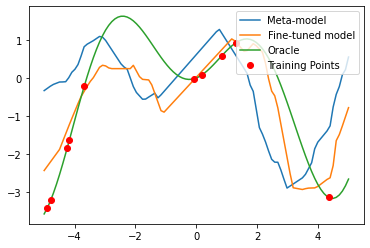

In [17]:
output = [saved_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
#output1 = [fine_tuned_once_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
#output2 = [fine_tuned_five_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
output3 = [fine_tuned_model2(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),output,label="Meta-model")
#plt.plot(x.cpu(),output1,label="Fine-tuned once")
#plt.plot(x.cpu(),output2,label="Fine-tuned five")
plt.plot(x.cpu(),output3,label="Fine-tuned model")
plt.plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Oracle")

plt.plot(x_train.cpu(),y_train.cpu(),'ro',label="Training Points")

plt.legend(loc="upper right")
plt.show()

## Comparison with pre-trained model

In [18]:
## Sample a task
## Sample K=10 data points
## Optimise

num_training_iter = 100000
pre_trained_model = Model()
pre_trained_model.to('cuda')
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(pre_trained_model.parameters(),lr=0.02)

for iter in tqdm(range(num_training_iter)):
  task = dist.sample_task()
  x_train,y_train = task.sample_data(10)
  loss = criterion(pre_trained_model(x_train),y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [21]:
pre_trained_model_copy = copy.deepcopy(pre_trained_model)

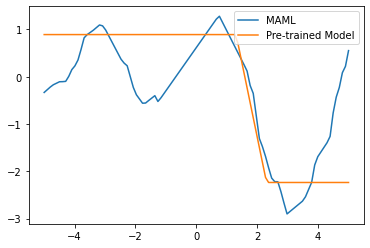

In [20]:
## Visualise pre-trained model
output_pre_trained = [pre_trained_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
output_MAML = [saved_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),output_MAML,label="MAML")
plt.plot(x.cpu(),output_pre_trained,label="Pre-trained Model")

plt.legend(loc="upper right")
plt.show()